In [12]:
import math
import columns
import thinkbayes
import thinkstats
import thinkplot
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

In [13]:
class Hockey(thinkbayes.Suite):
    """Represents hypotheses about the scoring rate for a team."""
    # section 7.1
    def __init__(self, name=''):
        """Initializes the Hockey object.

        name: string
        """
        mu = 2.7
        sigma = 0.3

        pmf = thinkbayes.MakeGaussianPmf(mu, sigma, 4)
        thinkbayes.Suite.__init__(self, pmf, name=name)
    
    # section 7.3
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one period
        """
        lam = hypo
        k = data
        like = thinkbayes.EvalPoissonPmf(k, lam)
        return like

#### ポアソン分布を選択してよい理由 [データ解析のための統計モデリング入門]
1. データに含まれる値が非負整数
1. データに下限がありそうだが上限はわからない
1. データの平均と分散がだいたい等しい



In [14]:
# 対戦結果:0-1,2-3,8-1,4-0
suite1 = Hockey('bruins')
suite1.UpdateSet([0, 2, 8, 4])
suite2 = Hockey('canucks')
suite2.UpdateSet([1, 3, 1, 0])

0.00057252023590806367

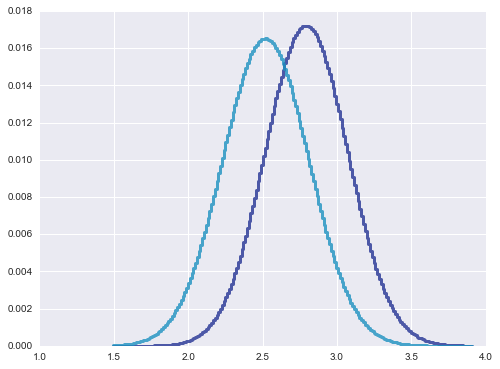

In [15]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(suite1)
thinkplot.Pmf(suite2)

In [16]:
# section 7.4 
# ゴール数の分布を作成
def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        pmf = thinkbayes.MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix

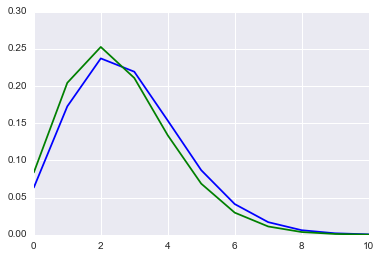

In [17]:
# section 7.4 ゴールの分布
goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)

def print_suite(suite1, suite2):
    X1 = [];Y1 = []
    X2 = [];Y2 = []

    for x,y in suite1.Items():
        X1.append(x)
        Y1.append(y)

    for x,y in suite2.Items():
        X2.append(x)
        Y2.append(y)

    plt.plot(X1,Y1, "b")
    plt.plot(X2,Y2, "g")

# ある1試合のゴールの分布
print_suite(goal_dist1, goal_dist2)

In [18]:
# section 7.5 勝つ確率
diff = goal_dist1 - goal_dist2 # 分布の差
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

# ブルーインズが勝つ確率, 負ける確率, 引き分ける確率
print p_win, p_loss, p_tie

0.45844446316 0.366927595518 0.174627941321


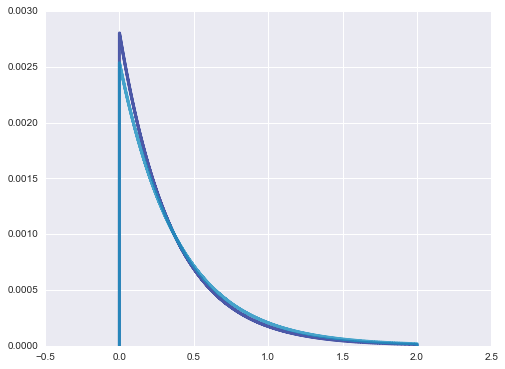

In [19]:
# section7.6 サドンデス

# ゴール間の時間の分布を作成
def MakeGoalTimePmf(suite):
    """Makes the distribution of time til first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        pmf = thinkbayes.MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix

# ゴールの間の時間の分布
time_dist1 = MakeGoalTimePmf(suite1)    
time_dist2 = MakeGoalTimePmf(suite2)
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmf(time_dist1)
thinkplot.Pmf(time_dist2)  

In [23]:
p_overtime = thinkbayes.PmfProbLess(time_dist1, time_dist2)

# サドンデスでブルーインズが勝つ確率
print 'p_overtime', p_overtime 

# 勝利の全体的確率は制限時間内に勝つ確率+延長時間に勝つ確率
p_win = diff.ProbGreater(0) + p_overtime * p_tie
print 'p_win', p_win

# 1シリーズ(3試合勝負)で勝利するには2試合先取する or 先2試合で一勝一敗かつ3試合目で勝ち
# win the next two
p_series = p_win**2

# split the next two, win the third
p_series += 2 * p_win * (1-p_win) * p_win

print 'p_series', p_series

p_overtime 0.524104237672
p_win 0.549967707223
p_series 0.574702044913
